In [219]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import glob
import os
import re
import pandas as pd
import tarfile
import P4J
from astropy.table import Table
from astropy.stats import sigma_clip
from astropy.cosmology import FlatLambdaCDM
from matplotlib.ticker import MaxNLocator
from astroML.time_series import ACF_scargle, ACF_EK
from statsmodels.tsa.stattools import acf
import matplotlib as mpl
#import PrettyTable as pt

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style="ticks", color_codes=True, context="notebook", font_scale=1.5)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

mainpath = '/Users/jorgetil/Astro/HITS'

In [9]:
def give_me_lc(field, CCD, X, Y, extract=False):
    year = field[:-3]
    try:
        #print "%s/lightcurves/%s/%s/%s/%s_%s_LC_50.tar.gz" % (mainpath, field[:-3], field, CCD, field, CCD)
        tar = tarfile.open("%s/lightcurves/%s/%s/%s/%s_%s_LC_50.tar.gz" 
                           % (mainpath, field[:-3], field, CCD, field, CCD))
        fil = tar.extractfile('%s_%s_%s_%s_g.dat' % (field, CCD, X, Y))
        if extract:
            tar.extract('%s_%s_%s_%s_g.dat' % (field, CCD, X, Y),
                    path='%s/lightcurves/examples/.' % mainpath)
    except:
        print 'No tar file or element in tar file'
        return None
    
    time, mag, err, epoch = [], [], [], []
    for line in fil:
        if line[0] == '#': continue
        values = line.split()
        epoch.append(float(values[0]))
        time.append(float(values[1]))
        mag.append(float(values[2]))
        err.append(float(values[3]))
    time = np.array(time)
    mag= np.array(mag)
    err = np.array(err)
    epoch = np.array(epoch)
    
    return time, mag, err, epoch

In [296]:
# load feature table into DF
qso_file = '%s/BH/HiTS_QSOvarTS_x_DR14Qv4.4.csv' % (mainpath)
qso = pd.read_csv(qso_file)
qso.set_index('internalID', inplace=True)
qso.dropna(subset=['Z'], inplace=True)

qso_cand_file = '%s/BH/HiTS_QSOvarCand_prob9.csv' % (mainpath)
qso_cand = pd.read_csv(qso_cand_file)
qso_cand.set_index('internalID', inplace=True)

In [297]:
print qso.shape
print qso_cand.shape

(143, 212)
(148, 88)


In [298]:
blz = ['Blind15A_24_S16_0651_2125', 'Blind15A_43_N17_1942_3873']
tsQSOfirst = ['Blind15A_34_N5_0305_1083', 'Blind14A_27_S19_0974_2199',
       'Blind15A_26_N6_1682_3690', 'Blind15A_25_N5_1564_2315',
       'Blind15A_06_N21_1770_2753', 'Blind15A_43_S21_0866_1556',
       'Blind15A_43_N17_1942_3873', 'Blind15A_24_S16_0651_2125']
tsQSOchandra = ['Blind15A_26_N3_0914_1699','Blind15A_26_N4_1000_3140',
                'Blind15A_26_S10_0794_3347','Blind15A_26_S12_1705_0484',
                'Blind15A_26_S16_0470_3958', 'Blind15A_26_S16_1510_3278',
                'Blind15A_06_S24_1981_1513']
varQSOsimbad = ['Blind15A_14_S8_0446_1355','Blind15A_27_N19_0351_0572',
                'Blind15A_38_S16_0145_0999','Blind15A_43_N31_0728_0441',
                'Blind15A_48_N22_1020_2334','Blind15A_28_N4_0536_1569']
varQSOfirst = ['Blind15A_07_S24_1037_1251','Blind15A_23_N26_1886_1994']
varQSOxmm = ['Blind14A_21_N13_1673_0102','Blind15A_25_N13_1848_1143']

In [299]:
qso.loc[blz, ['ID','Z', 'Mean']]

,ID,Z,Mean
internalID,,,
Blind15A_24_S16_0651_2125,HiTS094857+002225,0.5846,18.442488
Blind15A_43_N17_1942_3873,HiTS102834-023700,0.4710,18.722630


In [300]:
print 'm_g: ', qso_cand.loc['Blind15A_23_N26_1886_1994','Mean']
print 'S_g: ', np.power(10, 9.56 - qso_cand.loc['Blind15A_23_N26_1886_1994','Mean']/2.5)
print 'S_i: ', np.power(10, 9.56 - qso_cand.loc['Blind15A_23_N26_1886_1994','Mean']/2.5) * (4770./7625.)**0.44

m_g:  17.7473645609
S_g:  289.104049989
S_i:  235.1888504


In [301]:
# getting distance and absolute magnitudes using astropy.cosmology library
# with a Flat Lambda CDM universe
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, 
                      Tcmb0=2.725 * u.K, 
                      Om0=0.3,
                      Ob0=0.0486)
print cosmo
com_dist = cosmo.luminosity_distance(qso.Z)
# absolute mag of the galaxy from SDSS DR9
abs_gmag = qso.gmag + 5 - 5 * np.log10(com_dist.to(u.pc).value) - 2.5 * (-0.44 + 1) * np.log10(1 + qso.Z.values)
abs_imag = qso.imag + 5 - 5 * np.log10(com_dist.to(u.pc).value) - 2.5 * (-0.44 + 1) * np.log10(1 + qso.Z.values)

qso['gMag'] = abs_gmag
qso['iMag'] = abs_imag
qso['dist'] = com_dist
qso['S_i'] = np.power(10, 9.56 - qso.imag/2.5)
qso['S_i_K'] = qso.S_i * (1 + qso.Z)**(-0.56)
qso['FINT_K'] = qso.FINT * (1 + qso.Z)**(-0.2)
qso['R'] = (qso.FINT_K*1000) / qso.S_i_K

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=0.0486)


In [302]:
qso.loc[tsQSOfirst,['ID','raMedian','decMedian','Z','FPEAK','FINT','imag','iMag','S_i','R']].head(8)#.to_latex(index=False)

,ID,raMedian,decMedian,Z,FPEAK,FINT,imag,iMag,S_i,R
internalID,,,,,,,,,,
Blind15A_34_N5_0305_1083,HiTS101326-000136,153.358650,-0.026698,0.25500,1.21,1.688958,18.342281,-22.346836,167.142719,10.965874
Blind14A_27_S19_0974_2199,HiTS110401+002449,166.006721,0.413853,1.50400,2.50,3.022222,20.520342,-25.233651,22.483465,187.055943
Blind15A_26_N6_1682_3690,HiTS100326+020455,150.861058,2.081986,1.44370,4.32,4.521671,19.300000,-26.329477,69.183097,90.156331
Blind15A_25_N5_1564_2315,HiTS095147+020235,147.949497,2.043279,0.60550,6.14,6.056604,18.306999,-24.743778,172.663411,41.595716
Blind15A_06_N21_1770_2753,HiTS092142+010423,140.428307,1.073098,1.37410,8.60,8.908981,18.916000,-26.563348,98.537117,123.426332
Blind15A_43_S21_0866_1556,HiTS102601-013258,156.506997,-1.549495,1.45437,12.80,14.717451,20.708000,-24.943872,18.914724,1075.006303
Blind15A_43_N17_1942_3873,HiTS102834-023700,157.141824,-2.616794,0.47100,66.50,68.477430,18.389341,-23.951065,160.052867,491.614356
Blind15A_24_S16_0651_2125,HiTS094857+002225,147.239010,0.373865,0.58460,107.53,111.459130,18.280001,-24.670290,177.010784,743.167995


In [303]:
mask_no_radio = np.isnan(qso.R)
qso['FINT_lim_k'] = None
qso['R_lim'] = None
qso['FINT_lim_k'][mask_no_radio] = 1.0 * (1 + qso.Z)**(-0.2)
qso['R_lim'][mask_no_radio] = (qso.FINT_lim_k*1000) / qso.S_i_K

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


total:  135
loud:  28
inte:  98
quiet:  9
below 50:  62
53.1241916255
67.7070377978
52.2304796725


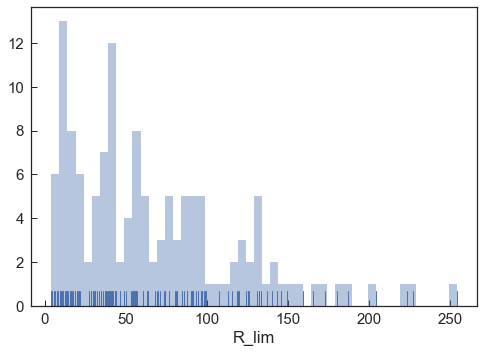

In [304]:
print 'total: ', len(qso[mask_no_radio])
print 'loud: ', len(qso[qso.R_lim > 100.])
print 'inte: ', len(qso[(qso.R_lim > 10.) & (qso.R_lim < 100.)])
print 'quiet: ', len(qso[qso.R_lim < 10.])
print 'below 50: ', len(qso[qso.R_lim < 50.])
print np.median(qso.R_lim)
print np.mean(qso.R_lim)
print np.std(qso.R_lim)
sns.distplot(qso.R_lim.dropna(), bins=50, kde=False, rug=True)
plt.show()

In [305]:
mask_cand_i = (qso_cand.Mean > 0) & (qso_cand['g-i'] > 0)
qso_cand['imag'] = qso_cand.Mean - qso_cand['g-i']

qso_cand['S_i'] = np.power(10, 9.56 - qso_cand.imag/2.5)
qso_cand['R_lim'] = (1.*1000) / qso_cand.S_i

#qso_cand[['raMedian','decMedian','Mean','Mean','g-i','imag','R_lim']].dropna()

total:  95
loud:  3
inter:  29
quiet:  71
< 50:  96
5.66573465573
14.2346635524
24.5264470507


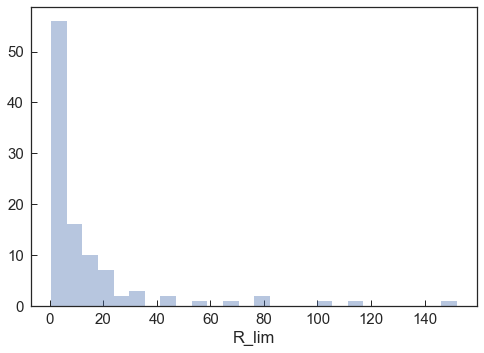

In [306]:
print 'total: ', len(qso_cand[mask_cand_i])
print 'loud: ',  len(qso_cand[qso_cand.R_lim > 100.])
print 'inter: ', len(qso_cand[(qso_cand.R_lim > 10.) & (qso_cand.R_lim < 100.)])
print 'quiet: ', len(qso_cand[qso_cand.R_lim < 10.])
print '< 50: ', len(qso_cand[qso_cand.R_lim < 50.])
print np.median(qso_cand.R_lim.dropna())
print np.mean(qso_cand.R_lim.dropna())
print np.std(qso_cand.R_lim.dropna())
sns.distplot(qso_cand.R_lim.dropna(), kde=False)
plt.show()

In [307]:
qso_cand.loc[varQSOfirst,['ID','raMedian','decMedian','Z','FPEAK','FINT','imag','iMag','S_i','R']]

,ID,raMedian,decMedian,Z,FPEAK,FINT,imag,iMag,S_i,R
internalID,,,,,,,,,,
Blind15A_07_S24_1037_1251,HiTS092023+001638,140.097084,0.277459,NaN,NaN,NaN,17.821336,NaN,270.063331,NaN
Blind15A_23_N26_1886_1994,HiTS094950-030557,147.458948,-3.099362,NaN,NaN,NaN,NaN,NaN,NaN,NaN


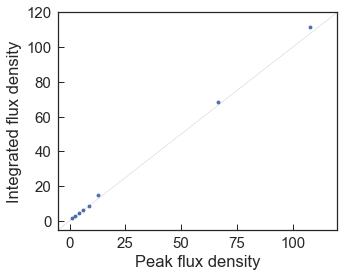

In [308]:
plt.figure(figsize=(5,4))
plt.scatter(qso.FPEAK, qso.FINT, marker='.', s=60, c='b', lw=0)
plt.plot([-5,120], [-5,120], '-k', lw=.1)
plt.xlim([-5,120])
plt.ylim([-5,120])
plt.xlabel('Peak flux density')
plt.ylabel('Integrated flux density')
plt.show()

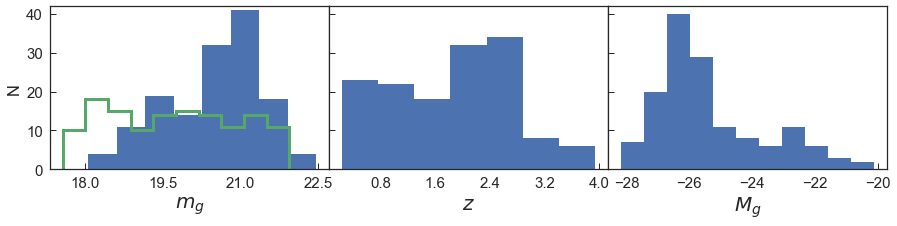

In [309]:
# plots of redshift distribution and more...
fig, ax = plt.subplots(ncols=3, nrows=1,figsize = (15,3), sharey=True)
sns.distplot(qso.Z, color='b', ax=ax[1], kde=False,
             hist_kws={"histtype": "stepfilled",
                       "linewidth": 0,
                       "alpha": 1})
ax[1].set_xlabel('$z$', size=20)
ax[0].set_ylabel('N')
nbins = len(ax[1].get_xticklabels())
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='both'))

sns.distplot(qso.gmag, color='b', ax=ax[0], kde=False,
             hist_kws={"histtype": "stepfilled",
                      "linewidth": 0,
                      "alpha": 1})
sns.distplot(qso_cand.query('Mean > 17.5').Mean, color='g', ax=ax[0], kde=False,
             hist_kws={"histtype": "step",
                      "linewidth": 2,
                      "alpha": 1, "linewidth":3}, bins=10)
ax[0].set_xlabel('$m_g$', size=20)
nbins = len(ax[0].get_xticklabels())
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='both'))

sns.distplot(qso.gMag, color='b', ax=ax[2], kde=False,
             hist_kws={"histtype": "stepfilled",
                      "linewidth": 0,
                      "alpha": 1})
ax[2].set_xlabel('$M_g$', size=20)
nbins = len(ax[2].get_xticklabels())
ax[2].xaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
'''
sns.distplot(qso[qso.FIRST_MATCHED== 1].FIRST_FLUX,
             color='b', ax=ax[1,0], kde=False, bins=50,
             hist_kws={"histtype": "step","linewidth": 2,"alpha": 1})
ax[1,0].set_xlabel('VLA-FIRST (20 cm)')
'''
plt.subplots_adjust(wspace=.0)
plt.ylim(0,42)
plt.savefig('%s/figures/varQSO_host.pdf' % (mainpath), format='pdf', dpi=600,
                bbox_inches='tight')
plt.show()

(18, 91)
(103,)
(130,)


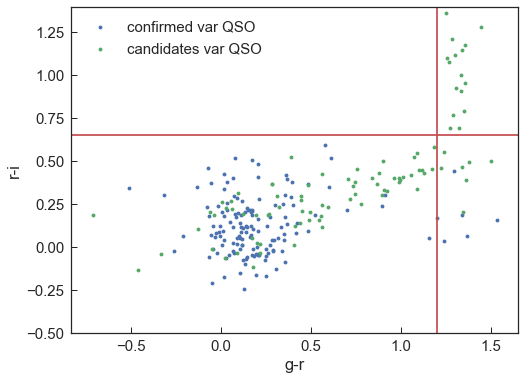

In [314]:
print qso_cand[(qso_cand['r-i'] > 0.65) & (qso_cand['g-r'] > 1.)].shape
print qso_cand['r-i'].dropna().shape
print qso_cand['g-r'].dropna().shape
plt.figure(figsize=(8,6))
plt.scatter(qso.gmag - qso.rmag, qso.rmag - qso.imag, marker='.', s=60, c='b', lw=0, label='confirmed var QSO')
plt.scatter(qso_cand['g-r'], qso_cand['r-i'], marker='.', s=60, c='g', lw=0, label='candidates var QSO')
plt.axvline(1.2, c='r')
plt.axhline(.65, c='r')
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.ylim(-0.5,1.4)
plt.show()

In [311]:
qso_cand[(qso_cand['r-i'] > 0.65) & (qso_cand['g-r'] > 1.)].index.values

array(['Blind15A_02_N13_1482_2366', 'Blind15A_02_S1_0648_2891',
       'Blind15A_06_N13_1000_2371', 'Blind15A_07_N24_1165_1074',
       'Blind15A_12_N24_0248_0298', 'Blind15A_13_N7_0778_0816',
       'Blind15A_14_N17_1350_0680', 'Blind15A_15_N29_1387_1614',
       'Blind15A_21_N24_1046_2569', 'Blind15A_22_N14_1534_2434',
       'Blind15A_25_N29_0250_2944', 'Blind15A_29_S11_0385_3475',
       'Blind15A_31_N10_0889_2800', 'Blind15A_38_N2_0294_3717',
       'Blind15A_39_S12_0248_0485', 'Blind15A_43_N15_0785_0957',
       'Blind15A_48_S8_1649_0752', 'Blind15A_49_N14_1072_0733'], dtype=object)

In [171]:
sdss = pd.read_csv('%s/SDSS/SDSS_star_qso.csv' % (mainpath),
                   names=['u','g','r','i','z','zsp','zerr','clase','type'], skiprows=1)

In [176]:
sdss.dtypes

u        float64
g        float64
r        float64
i        float64
z        float64
zsp      float64
zerr     float64
clase     object
type      object
dtype: object

In [220]:
print sdss.shape
sdss['g_r'] = sdss.g - sdss.r
sdss['r_i'] = sdss.r - sdss.i
sdss = sdss.query('g_r > -1 and g_r < 3 and r_i > -1 and r_i < 3')
print sdss.shape

(1260840, 11)
(1255293, 11)


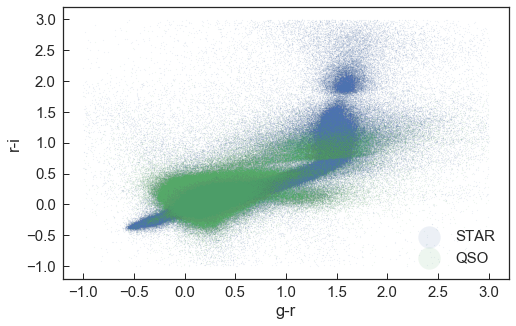

In [221]:
plt.figure(figsize=(8,5))
plt.scatter(sdss.query('clase == "STAR"').g_r,
            sdss.query('clase == "STAR"').r_i,
            marker='.', s=5, alpha=.1, c='b', 
            lw=0, label='STAR')
plt.scatter(sdss.query('clase == "QSO"').g_r,
            sdss.query('clase == "QSO"').r_i,
            marker='.', s=5, alpha=.1, c='g', 
            lw=0, label='QSO')
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.legend(markerscale=20)
plt.show()

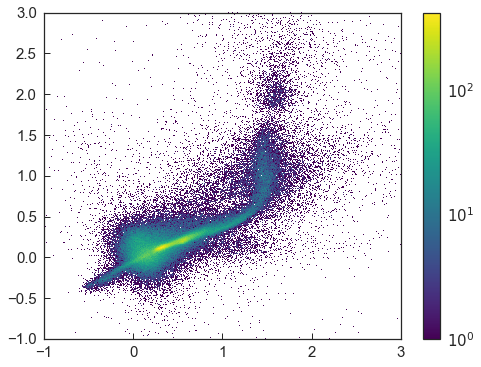

In [222]:
f, ax = plt.subplots(figsize=(8,6))
cax = ax.hist2d(sdss.g_r, sdss.r_i,
                bins=1000, cmap='viridis',
                norm=mpl.colors.LogNorm())
f.colorbar(cax[3])
plt.show()

In [240]:
def rotate(matrix, degree):
    if abs(degree) not in [0, 90, 180, 270, 360]:
        return matrix
        # raise error or just return nothing or original
    if degree == 0:
        return matrix
    elif degree > 0:
        return rotate(zip(*matrix[::-1]), degree-90)
    else:
        return rotate(zip(*matrix)[::-1], degree+90)

[-0.9795233 -0.1796553  0.6202127  1.4200807  2.2199487]


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


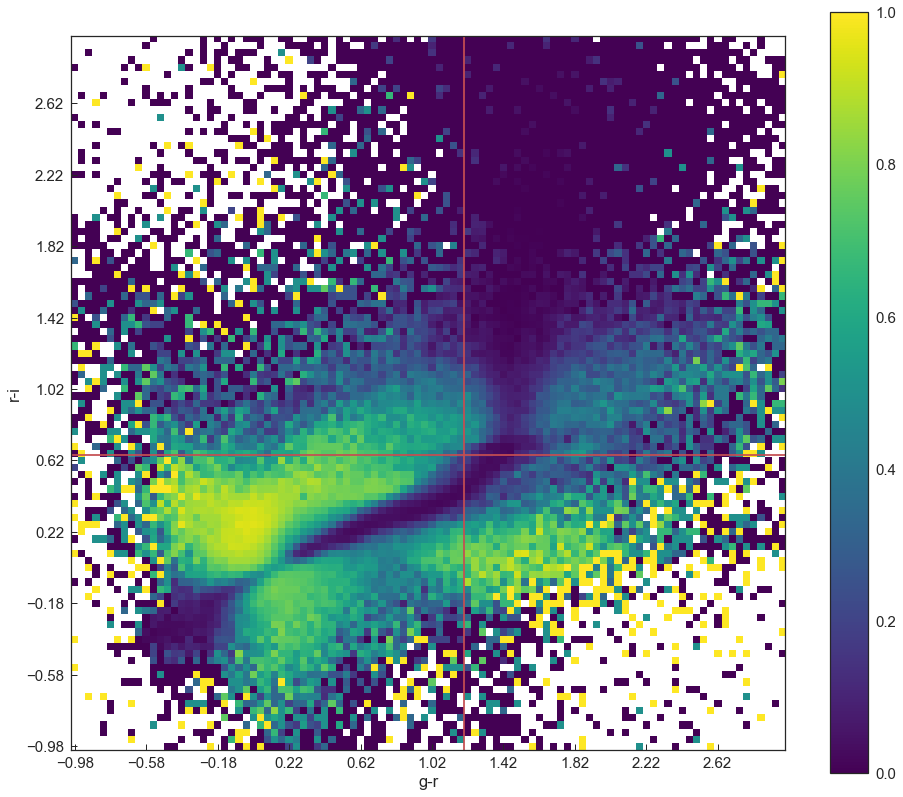

In [315]:
all_2d, xedge_all, yedge_all = np.histogram2d(sdss.g_r,
                                              sdss.r_i, bins=100)
qso_2d,_, _ = np.histogram2d(sdss.query('clase == "QSO"').g_r,
                             sdss.query('clase == "QSO"').r_i, 
                             bins=[xedge_all,yedge_all])
xlab = (xedge_all[1:] + xedge_all[:-1])/2
ylab = (yedge_all[1:] + yedge_all[:-1])/2
print xlab[::20]
f, ax = plt.subplots(figsize=(16,14))
cax = ax.imshow(rotate(qso_2d / all_2d, -90),
                cmap='viridis', extent=[-1, 3, -1, 3])
f.colorbar(cax)
ax.set_xticks(xlab[::10])
ax.set_yticks(ylab[::10])
ax.set_xlabel('g-r')
ax.set_ylabel('r-i')
ax.axvline(1.2, c='r')
ax.axhline(.65, c='r')
plt.show()

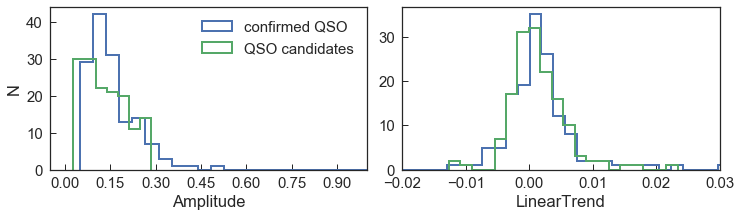

In [48]:
# plots of redshift distribution and more...
fig, ax = plt.subplots(ncols=2, nrows=1,figsize = (12,3), sharey=False)
sns.distplot(qso.Amplitude*2, color='b', ax=ax[0], kde=False,
             hist_kws={"histtype": "step",
                       "linewidth": 2.,
                       "alpha": 1}, label='confirmed QSO')
sns.distplot(qso_cand.Amplitude*2, color='g', ax=ax[0], kde=False,
             hist_kws={"histtype": "step",
                       "linewidth": 2.,
                       "alpha": 1}, label='QSO candidates')
#ax[0].set_xlabel('$Amplitude$', size=20)
ax[0].set_ylabel('N')
ax[0].set_xlim(-.05, 1)
nbins = len(ax[0].get_xticklabels())
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='both'))
ax[0].legend(loc='best')

sns.distplot(qso.LinearTrend, color='b', ax=ax[1], kde=False,
             hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": 1})
sns.distplot(qso_cand.LinearTrend, color='g', ax=ax[1], kde=False,
             hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": 1})
ax[1].set_xlim(-.02, 0.03)
#ax[1].set_xlabel('$Stetson K$', size=20)
nbins = len(ax[1].get_xticklabels())
#ax[1].xaxis.set_major_locator(MaxNLocator(nbins=nbins[::2], prune='both'))

'''
sns.distplot(qso.Eta_e, color='b', ax=ax[2], kde=False,
             hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": 1})
sns.distplot(qso_cand.Eta_e, color='g', ax=ax[2], kde=False,
             hist_kws={"histtype": "step",
                      "linewidth": 2.,
                      "alpha": 1})
#ax[2].set_xlabel('$\eta^{e}$', size=20)
nbins = len(ax[2].get_xticklabels())
ax[2].xaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='both'))

sns.distplot(qso[qso.FIRST_MATCHED== 1].FIRST_FLUX,
             color='b', ax=ax[1,0], kde=False, bins=50,
             hist_kws={"histtype": "step","linewidth": 2,"alpha": 1})
ax[1,0].set_xlabel('VLA-FIRST (20 cm)')
'''
plt.subplots_adjust(wspace=.11)

plt.savefig('%s/figures/feat_qso.pdf' % (mainpath), format='pdf', dpi=600,
                bbox_inches='tight')
plt.show()

Blind15A_07_S9_1016_4031 PeriodLS       50.0712
Period_fit    0.105417
Name: Blind15A_07_S9_1016_4031, dtype: object


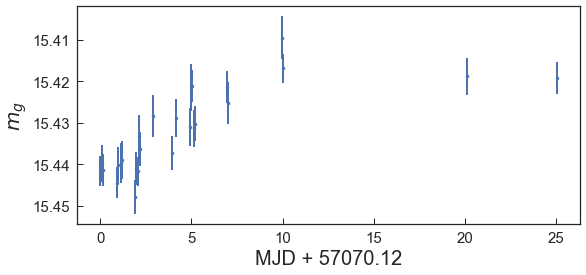

Blind15A_46_S17_1221_2144 PeriodLS      5.77214
Period_fit     0.2455
Name: Blind15A_46_S17_1221_2144, dtype: object


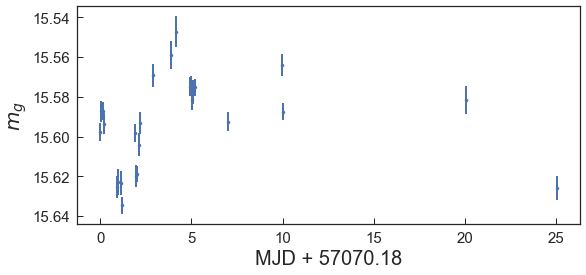

Blind15A_13_S25_0094_1274 PeriodLS        25.0317
Period_fit    0.0343507
Name: Blind15A_13_S25_0094_1274, dtype: object


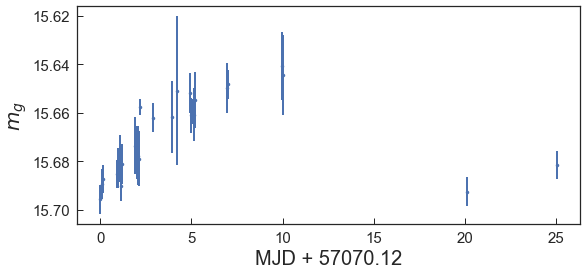

Blind15A_28_N1_1118_2791 PeriodLS        6.82623
Period_fit    0.0380484
Name: Blind15A_28_N1_1118_2791, dtype: object


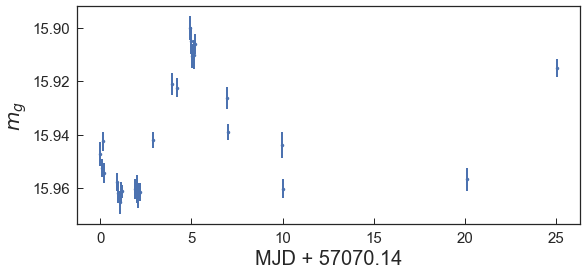

Blind14A_28_N4_0784_1746 PeriodLS       6.42201
Period_fit    0.319068
Name: Blind14A_28_N4_0784_1746, dtype: object


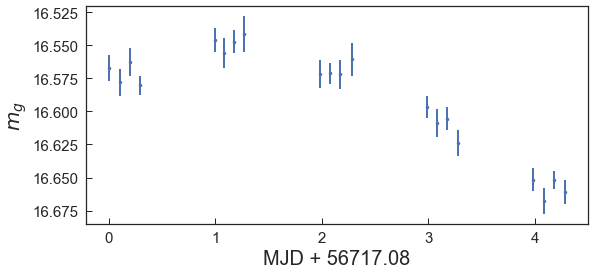

Blind15A_36_S28_0348_0380 PeriodLS        12.5148
Period_fit    0.0718821
Name: Blind15A_36_S28_0348_0380, dtype: object


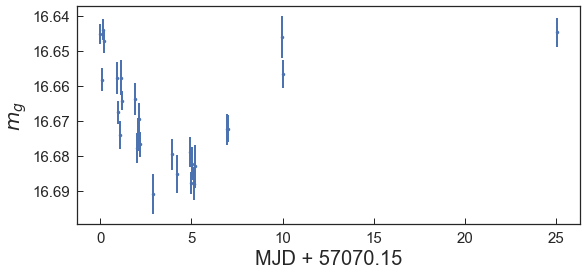

Blind15A_18_N8_1797_2175 PeriodLS        8.83383
Period_fit    0.0887956
Name: Blind15A_18_N8_1797_2175, dtype: object


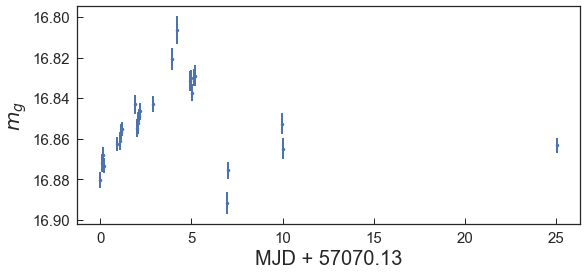

Blind15A_08_N19_0316_0778 PeriodLS         6.8279
Period_fit    0.0289774
Name: Blind15A_08_N19_0316_0778, dtype: object


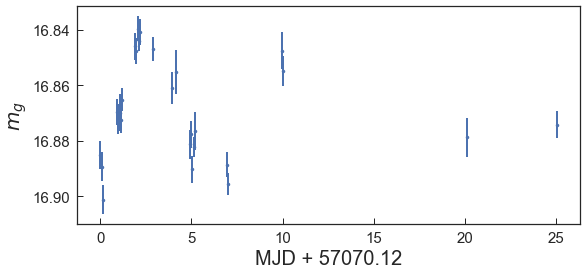

Blind15A_02_N10_0225_3756 PeriodLS       50.0735
Period_fit    0.314029
Name: Blind15A_02_N10_0225_3756, dtype: object


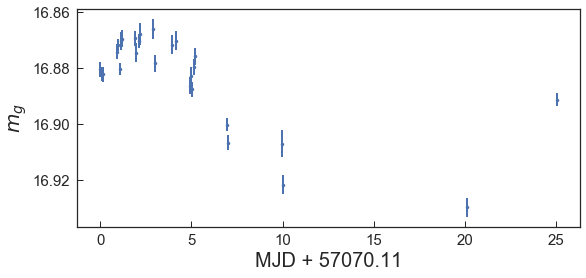

Blind15A_35_S1_1604_1913 PeriodLS       37.5444
Period_fit    0.243382
Name: Blind15A_35_S1_1604_1913, dtype: object


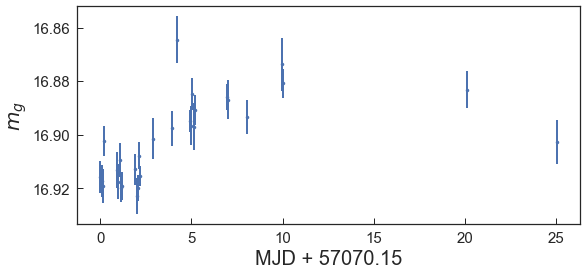

Blind15A_23_N6_1736_3639 PeriodLS       50.0586
Period_fit    0.225527
Name: Blind15A_23_N6_1736_3639, dtype: object


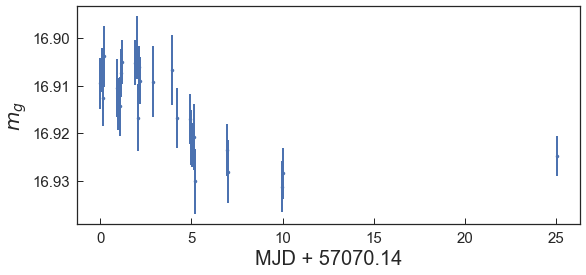

Blind15A_32_S13_0303_0416 PeriodLS       5.36348
Period_fit    0.109796
Name: Blind15A_32_S13_0303_0416, dtype: object


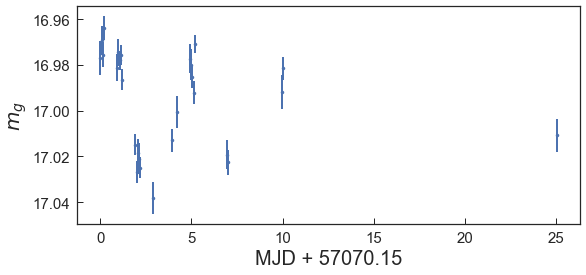

Blind14A_21_N13_1673_0102 PeriodLS       10.7424
Period_fit    0.152158
Name: Blind14A_21_N13_1673_0102, dtype: object


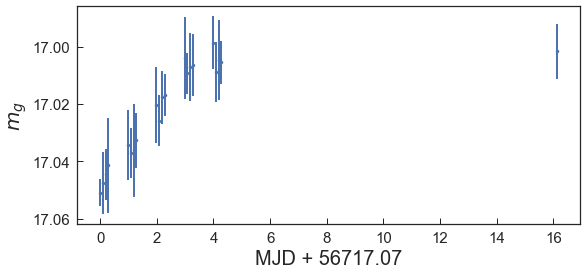

Blind15A_28_S5_1910_0508 PeriodLS       6.25737
Period_fit    0.316042
Name: Blind15A_28_S5_1910_0508, dtype: object


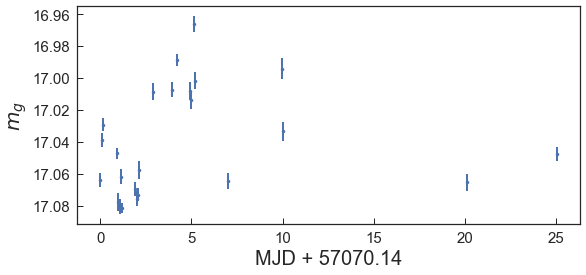

Blind15A_34_S25_1103_1469 PeriodLS        50.0592
Period_fit    0.0631505
Name: Blind15A_34_S25_1103_1469, dtype: object


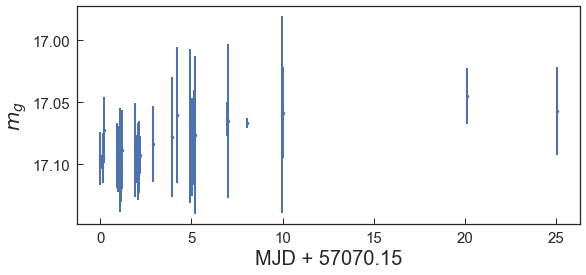

Blind15A_23_N11_0424_3035 PeriodLS        6.82618
Period_fit    0.0487716
Name: Blind15A_23_N11_0424_3035, dtype: object


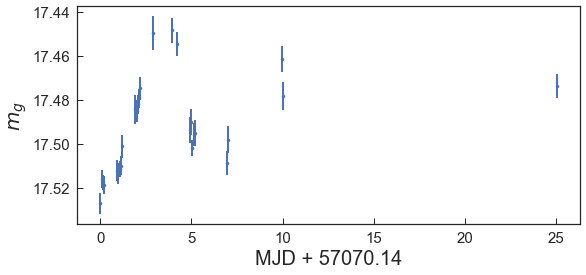

Blind15A_04_S24_1747_1383 PeriodLS       60.1754
Period_fit    0.260795
Name: Blind15A_04_S24_1747_1383, dtype: object


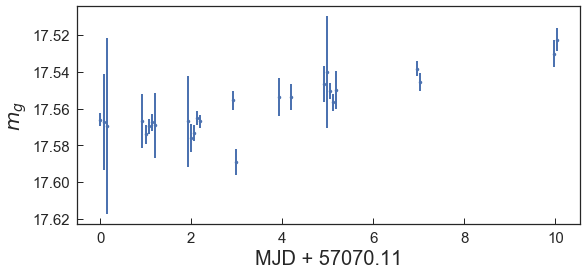

Blind15A_40_N11_1175_3317 PeriodLS        50.0597
Period_fit    0.0167353
Name: Blind15A_40_N11_1175_3317, dtype: object


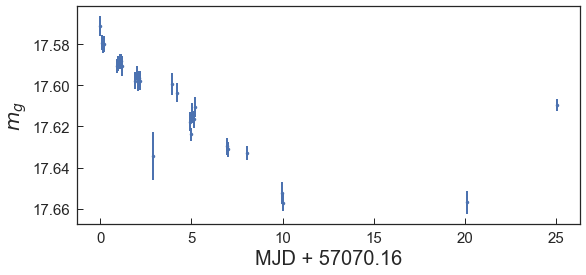

Blind15A_08_S24_1190_0859 PeriodLS       25.0356
Period_fit    0.115184
Name: Blind15A_08_S24_1190_0859, dtype: object


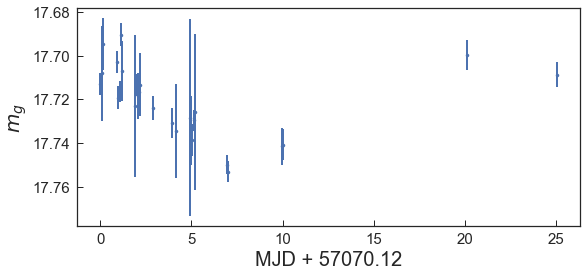

Blind14A_25_N3_1137_1540 PeriodLS       3.20929
Period_fit    0.400086
Name: Blind14A_25_N3_1137_1540, dtype: object


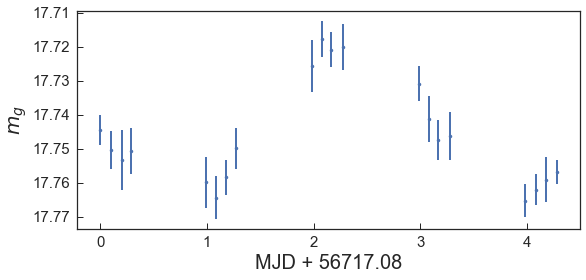

Blind15A_23_N26_1886_1994 PeriodLS       75.088
Period_fit    0.11613
Name: Blind15A_23_N26_1886_1994, dtype: object


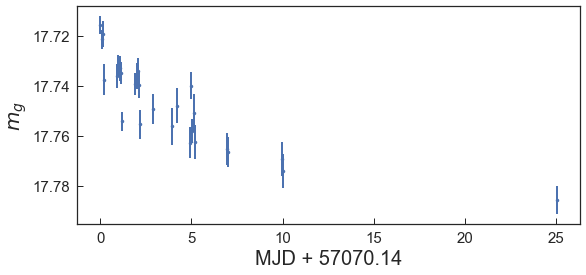

Blind15A_07_N20_0656_1915 PeriodLS      0.0688737
Period_fit     0.354113
Name: Blind15A_07_N20_0656_1915, dtype: object


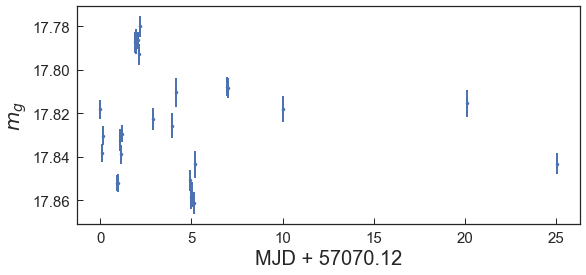

Blind15A_41_S15_0870_3968 PeriodLS      50.0598
Period_fit    0.11526
Name: Blind15A_41_S15_0870_3968, dtype: object


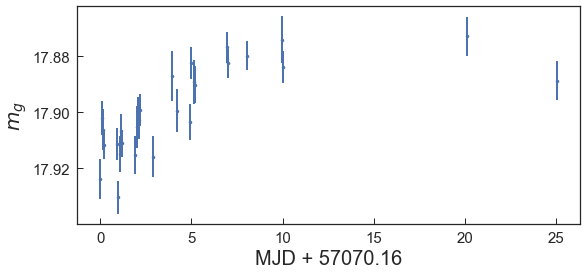

Blind15A_43_N31_0728_0441 PeriodLS          50.06
Period_fit    0.0728631
Name: Blind15A_43_N31_0728_0441, dtype: object


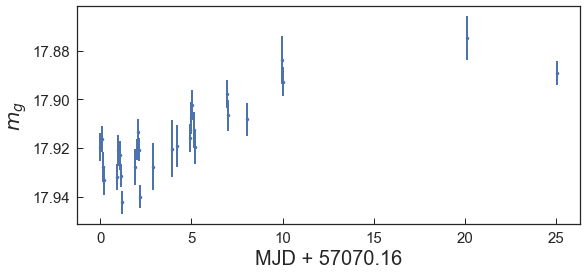

Blind15A_32_N18_1524_1599 PeriodLS        3.19527
Period_fit    0.0776835
Name: Blind15A_32_N18_1524_1599, dtype: object


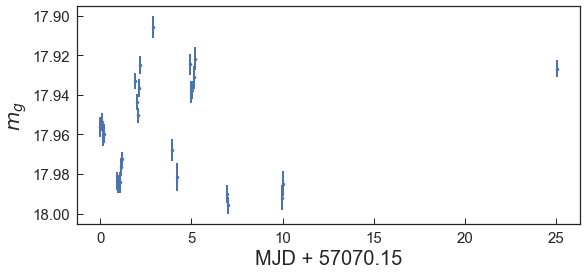

Blind14A_33_S19_1288_1028 PeriodLS       3.21034
Period_fit    0.508579
Name: Blind14A_33_S19_1288_1028, dtype: object


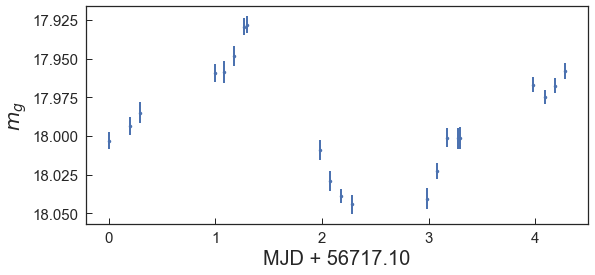

Blind15A_33_S31_1701_1391 PeriodLS        18.7722
Period_fit    0.0484145
Name: Blind15A_33_S31_1701_1391, dtype: object


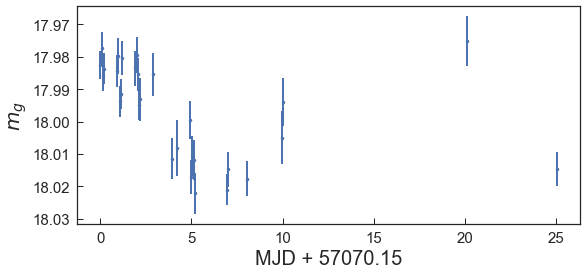

Blind15A_07_S26_0946_3104 PeriodLS       7.51067
Period_fit    0.196779
Name: Blind15A_07_S26_0946_3104, dtype: object


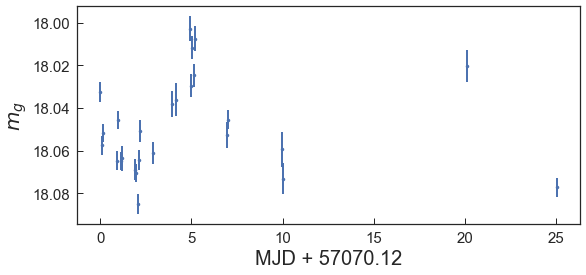

Blind14A_25_S18_0275_0564 PeriodLS       25.6743
Period_fit    0.229385
Name: Blind14A_25_S18_0275_0564, dtype: object


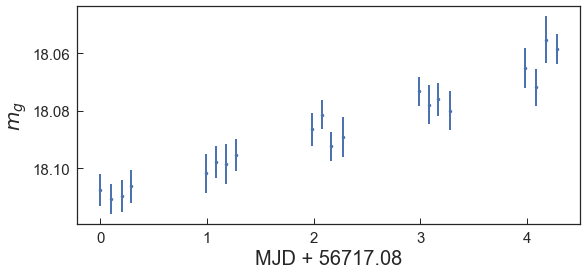

Blind15A_31_N10_0889_2800 PeriodLS       50.0592
Period_fit    0.126293
Name: Blind15A_31_N10_0889_2800, dtype: object


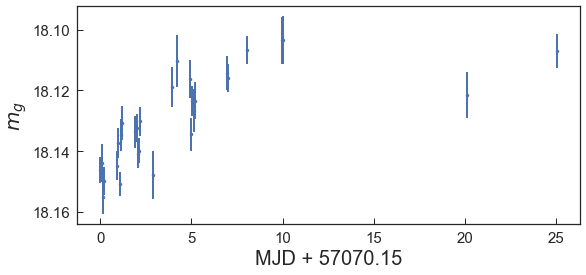

Blind14A_33_N24_0891_1337 PeriodLS      3.66896
Period_fit    0.19722
Name: Blind14A_33_N24_0891_1337, dtype: object


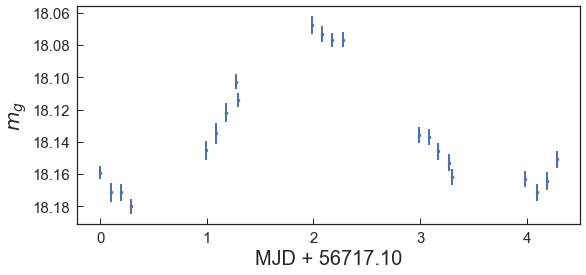

Blind15A_22_S11_1841_0595 PeriodLS        37.544
Period_fit    0.157752
Name: Blind15A_22_S11_1841_0595, dtype: object


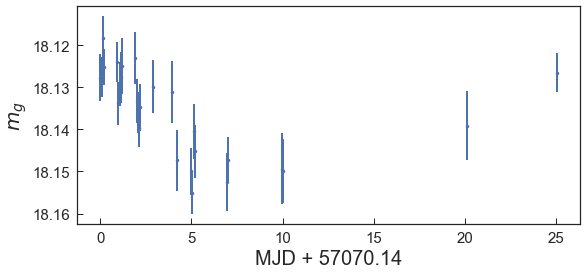

Blind15A_21_N3_0336_0629 PeriodLS       6.50709
Period_fit    0.582479
Name: Blind15A_21_N3_0336_0629, dtype: object


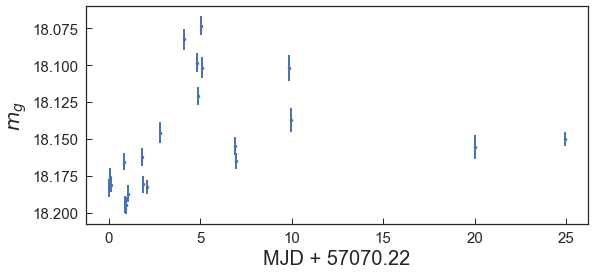

Blind15A_07_N24_1165_1074 PeriodLS        37.5534
Period_fit    0.0623898
Name: Blind15A_07_N24_1165_1074, dtype: object


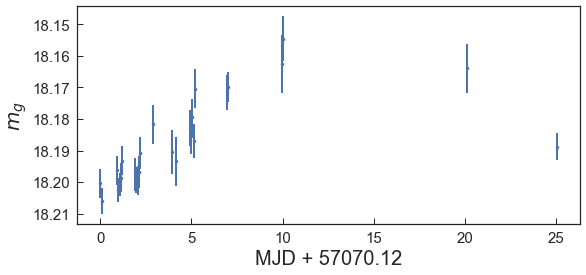

Blind15A_29_S4_1269_1897 PeriodLS       25.0295
Period_fit    0.284191
Name: Blind15A_29_S4_1269_1897, dtype: object


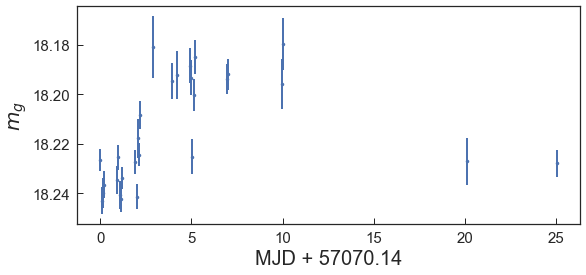

Blind15A_31_S9_0085_2127 PeriodLS        12.5148
Period_fit    0.0398767
Name: Blind15A_31_S9_0085_2127, dtype: object


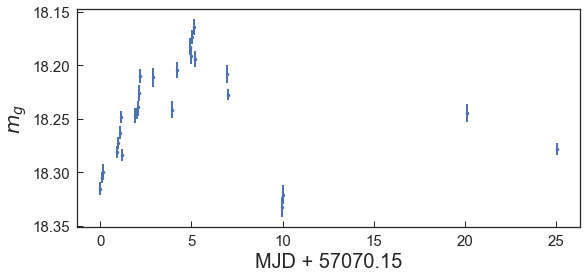

Blind15A_35_S2_0474_2894 PeriodLS        13.6525
Period_fit    0.0533863
Name: Blind15A_35_S2_0474_2894, dtype: object


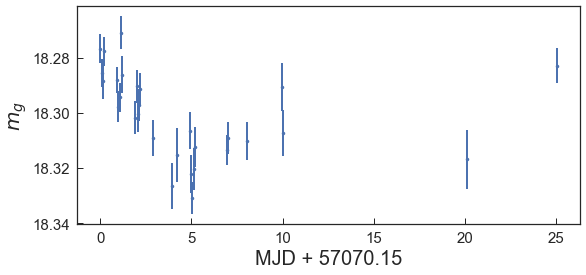

Blind15A_25_N13_1848_1143 PeriodLS       6.52939
Period_fit    0.036201
Name: Blind15A_25_N13_1848_1143, dtype: object


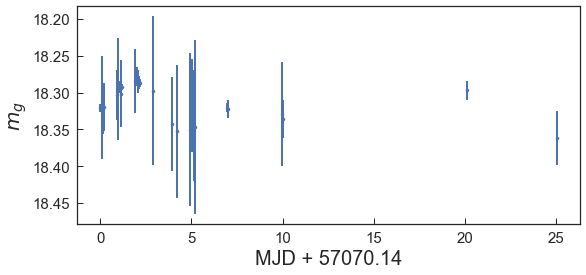

Blind15A_48_S8_1649_0752 PeriodLS         10.005
Period_fit    0.0415993
Name: Blind15A_48_S8_1649_0752, dtype: object


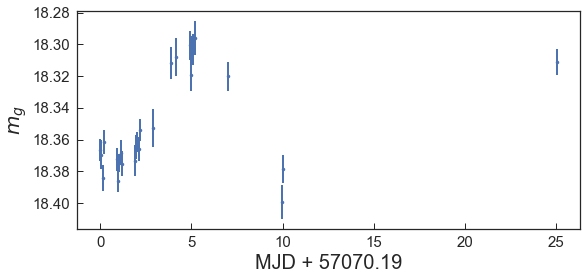

Blind14A_12_N19_0078_3558 PeriodLS       6.44634
Period_fit    0.416644
Name: Blind14A_12_N19_0078_3558, dtype: object


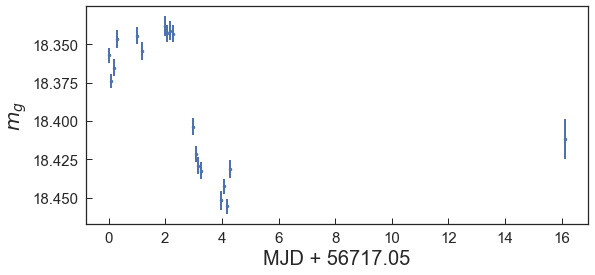

Blind15A_19_S2_1859_0296 PeriodLS      1.19187
Period_fit    0.41484
Name: Blind15A_19_S2_1859_0296, dtype: object


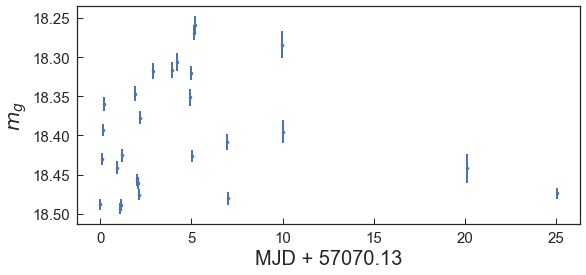

Blind15A_14_S8_0446_1355 PeriodLS        16.6878
Period_fit    0.0257899
Name: Blind15A_14_S8_0446_1355, dtype: object


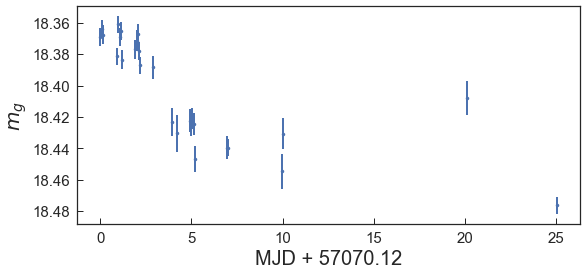

Blind15A_18_N14_0937_0332 PeriodLS       25.0292
Period_fit    0.049579
Name: Blind15A_18_N14_0937_0332, dtype: object


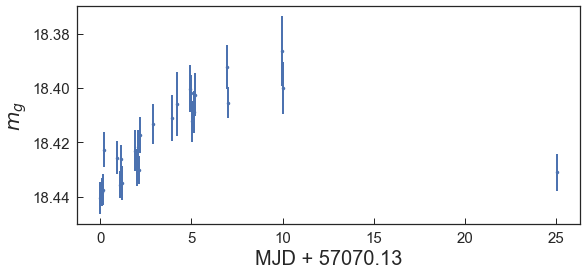

Blind15A_17_S25_0413_3849 PeriodLS       20.0593
Period_fit    0.166469
Name: Blind15A_17_S25_0413_3849, dtype: object


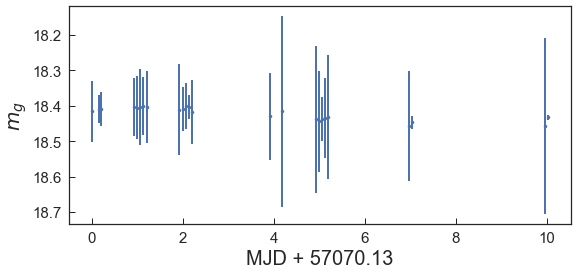

Blind15A_02_N13_1482_2366 PeriodLS        16.6912
Period_fit    0.0601985
Name: Blind15A_02_N13_1482_2366, dtype: object


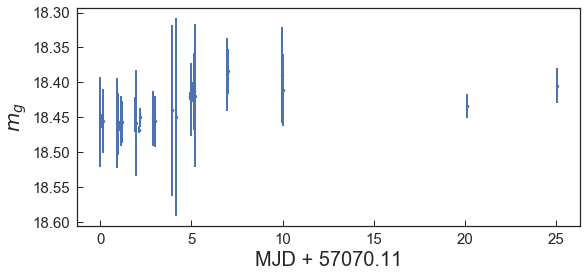

Blind15A_41_N22_0373_3509 PeriodLS        75.0897
Period_fit    0.0256908
Name: Blind15A_41_N22_0373_3509, dtype: object


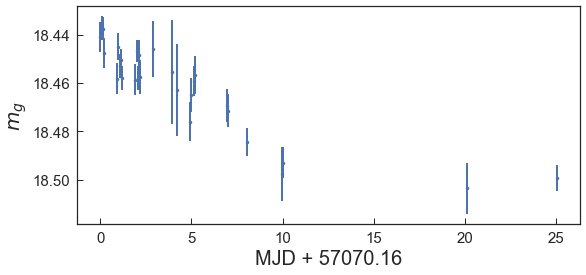

Blind15A_11_S12_0495_2398 PeriodLS        15.0443
Period_fit    0.0589932
Name: Blind15A_11_S12_0495_2398, dtype: object


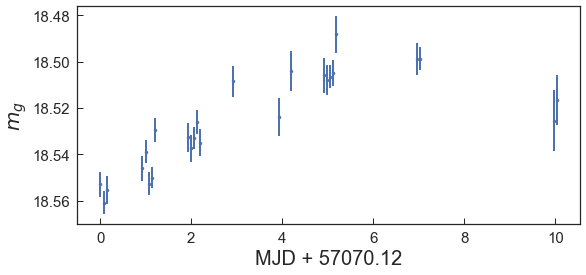

Blind15A_33_N6_1521_2397 PeriodLS        50.0592
Period_fit    0.0237672
Name: Blind15A_33_N6_1521_2397, dtype: object


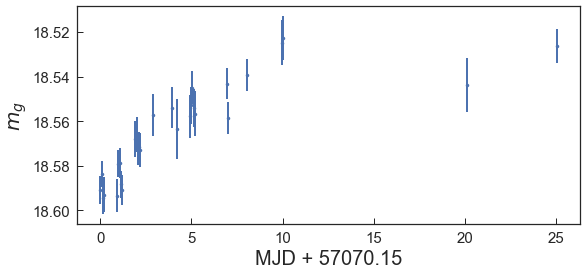

Blind15A_04_N20_1335_3646 PeriodLS        10.0292
Period_fit    0.0403612
Name: Blind15A_04_N20_1335_3646, dtype: object


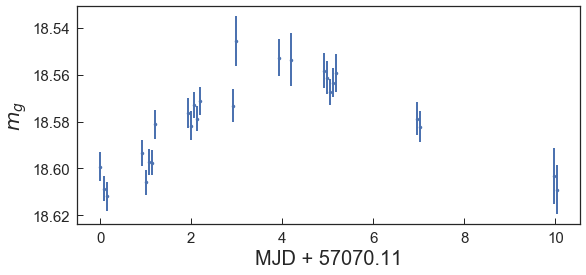

Blind14A_39_N6_1705_1004 PeriodLS      0.114633
Period_fit      0.2929
Name: Blind14A_39_N6_1705_1004, dtype: object


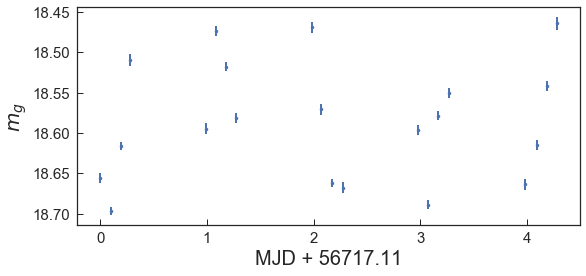

In [73]:
ls = []
periodogram = True
#for idx, row in table_15.sort_values(['Pred_Var_Type', 'Pred_proba'],ascending=False).iterrows():
for idx, row in qso_cand.sort_values('Mean', ascending=True).head(50).iterrows():
#for idx, row in qso.head(10).iterrows():
    #if idx != 'Blind15A_21_N21_1122_2101': continue
    print '\r',idx,
    label = row['Var_Type']
    #print row[['raMedian','decMedian']].astype(float)
    #print row[['raMedian','decMedian','X','Y','Var_Type','Mean','Amplitude',
    #           'Std','MedianAbsDev','Meanvariance','Eta_e', 'spCl','spSubCl','Z','Period_fit','PeriodLS']]
    T = float(row['PeriodLS'])
    print row[['PeriodLS','Period_fit']]
    T_W = float(row['PeriodLS'])
    T_G = float(row['PeriodGLS'])
    field, CCD, X, Y = re.findall(
            r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', idx)[0]
    #try:
    time, mag, err, epoch = give_me_lc(field, CCD, X, Y, extract=False)
    #continue
    #except:
    #    print 'fail during LC read'
    #    continue
    #continue
    
    goods = np.where(mag>=15.)
    time = time[goods]
    mag = mag[goods]
    err = err[goods]
    
    filtered_data = sigma_clip(mag, sigma=3, iters=3,
                           cenfunc=np.mean, copy=False)
    time = time[~filtered_data.mask]
    mag = mag[~filtered_data.mask]
    err = err[~filtered_data.mask]
    epoch = epoch[~filtered_data.mask]
    #print 'clipped: ', np.sum(filtered_data.mask)
    
    t_aux = time[time - time.min() < 6]
    ls.append(np.median(t_aux[3:] - t_aux[:-3]))
    #continue
        
    C_EK, C_EK_err, bins = ACF_EK(time - time.min(), mag, err,
                                  bins=np.linspace(0, 4, 101))
    t_EK = 0.5 * (bins[1:] + bins[:-1])
    
    ts_acf = acf(mag)
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (9,4))
    
    ax.errorbar(time - time.min(), mag, yerr=err, fmt='b.', lw=2.)
    #if np.max(time - time.min()) > 10:
    #    ax.set_xlim(-0.1, 6.)
    ax.set_xlabel('MJD + %.2f' % time.min(), size=20)
    ax.set_ylabel('$m_g$', size=20)
    ax.invert_yaxis()
    #plt.savefig('%s/figures/Blazar_%s.pdf' % (mainpath, idx), format='pdf', dpi=600,
    #            bbox_inches='tight')
    plt.show()
    
    #plt.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1,
    #            label='Edelson-Krolik')
    #plt.fill_between(t_EK, 0, C_EK_err*3., alpha=.3)
    #plt.fill_between(t_EK, 0, -C_EK_err*3., alpha=.3)
    ##plt.plot(ts_acf, '.k', ms=10)
    #plt.legend(loc=3)
    #plt.axhline(0, ls=':', lw=1, c='gray')
    #
    #plt.xlabel('t (days)')
    #plt.ylabel('ACF(t)')
    #plt.show()
    ##break

In [50]:
print np.median(ls)

0.860832500002
